In [1]:
# ----- basic imports ----- #
from collections import Counter
import pandas as pd
import numpy as np
import itertools
import warnings
import csv
warnings.filterwarnings('ignore')

# ----- matplotlib stuff ----- #
import matplotlib.pyplot as plt
from matplotlib import markers
import matplotlib.cm

# ----- sklearn stuff ----- #
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.preprocessing import MultiLabelBinarizer
from scipy.spatial.distance import pdist, squareform
from skbio.stats.distance import mantel
import skbio

# ----- geo stuff ----- #
from geovoronoi.plotting import subplot_for_map, plot_points, plot_voronoi_polys_with_points_in_area, plot_polygon_collection_with_color
from geovoronoi import voronoi_regions_from_coords, points_to_coords
from shapely.ops import unary_union
import geopandas as gpd

### Building Features Matrices

In [2]:
with open ('allmaps.txt', 'r') as f:
    strings = f.readlines()

vectors = {}
for string in strings:
    string = string.split(' ')
    settlement, vector = string[0], string[1].strip()
    vectors[settlement] = [int(x) for x in list(vector)]

In [3]:
features = pd.DataFrame.from_dict(vectors, orient='index')
features = features[~(features.sum(axis=1) < 25)]
features.columns += 1

#### Whole Atlas Features

The following 4195 x 4416 matrix, where 4195 is the number of settlements and 4416 is the number of features, contains all the features from the atlas

In [4]:
features

,1,2,3,4,5,6,7,8,9,10,...,4407,4408,4409,4410,4411,4412,4413,4414,4415,4416
10001,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10002,0,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
10003,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
10004,0,0,0,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
10005,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50833,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
50834,1,1,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
50835,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
50836,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Values Matrices

Bits distribution for each atlas value goes as follows

| MORPHOLOGY  | PHONETICS   | SYNTAX      | LEXIS       |
| ----------- | ----------- | ----------- | ----------- |
| 835         | 725         | 66           | 2790       |

In [5]:
morphology = features.iloc[:, 0:835]
morphology = morphology.drop(284, axis=1)
morphology = morphology.drop(588, axis=1)
morphology = morphology.drop(717, axis=1)

phonetics = features.iloc[:, 835:1560]
syntax = features.iloc[:, 1560:1625]
lexis = features.iloc[:, 1626:4416]

In [7]:
VALUE = 'morphology'

In [6]:
feature_names = {}
with open ('{}_features_csv.csv'.format(VALUE), 'r') as f:
    feature_name = f.readlines()
for f in feature_name:
    f = f.split(';')
    feature_names[int(f[0])] = f[1]+'. '+f[2]+'. '+f[3].strip()

### Merging Unstable Features

In [8]:
def merge_severities_pandas(df, mapping_dict, starting_point):
    output_df = pd.DataFrame(columns=range(len(mapping_dict)), index=df.index)

    for index, row in df.iterrows():
        for bit_index, value in enumerate(row):
            if value == 1:
                for feature_index, severities in mapping_dict.items():
                    for severity in severities:
                        if severity[0] == bit_index + starting_point:
                            output_df.at[index, feature_index] = severity[1]
        output_df.loc[index] = output_df.loc[index].fillna(0)
    
    return output_df

In [9]:
merging = {
    'morphology': [[(1, 1)], [(2, 1)], [(3, 1)], [(4, 1)], [(5, 1)], [(6, 1)], [(7, 1)], [(8, 1)], [(9, 1)], [(10, 1)], [(11, 1)], [(12, 1)], [(13, 1)], [(14, 1)], [(15, 1)], [(16, 1)], [(17, 1)], [(18, 1)], [(19, 1)], [(20, 1)], [(21, 1)], [(22, 1)], [(23, 1)], [(24, 1)], [(25, 1)], [(26, 1)], [(27, 1)], [(28, 1)], [(29, 1)], [(30, 1)], [(31, 1)], [(32, 1)], [(33, 1)], [(34, 1)], [(35, 1)], [(36, 1)], [(37, 1)], [(38, 1)], [(39, 1)], [(40, 1)], [(41, 1)], [(42, 1)], [(43, 1)], [(44, 1)], [(45, 1)], [(46, 1)], [(47, 1)], [(48, 1)], [(49, 1)], [(50, 1)], [(51, 1)], [(52, 1)], [(53, 1)], [(54, 1)], [(55, 1)], [(56, 1)], [(57, 1)], [(58, 1)], [(59, 1)], [(60, 1)], [(61, 1)], [(62, 1)], [(63, 1)], [(64, 1)], [(65, 1)], [(66, 1)], [(67, 1)], [(68, 1)], [(69, 1)], [(70, 1)], [(71, 1)], [(72, 1)], [(73, 1)], [(74, 1)], [(75, 1)], [(76, 1)], [(77, 1), (78, 0.6)], [(79, 1), (80, 0.6)], [(81, 1)], [(82, 1)], [(83, 1)], [(84, 1)], [(85, 1)], [(86, 1)], [(87, 1)], [(88, 1)], [(89, 1)], [(90, 1)], [(91, 1)], [(92, 1)], [(93, 1)], [(94, 1)], [(95, 1)], [(96, 1)], [(97, 1)], [(98, 1)], [(99, 1)], [(100, 1)], [(101, 1)], [(102, 1)], [(103, 1)], [(104, 1)], [(105, 1)], [(106, 1)], [(107, 1)], [(108, 1)], [(109, 1)], [(110, 1)], [(111, 1)], [(112, 1)], [(113, 1)], [(114, 1)], [(115, 1)], [(116, 1)], [(117, 1)], [(118, 1)], [(119, 1)], [(120, 1)], [(121, 1)], [(122, 1)], [(123, 1)], [(124, 1)], [(125, 1)], [(126, 1)], [(127, 1)], [(128, 1)], [(129, 1)], [(130, 1)], [(131, 1)], [(132, 1)], [(133, 1)], [(134, 1)], [(135, 1)], [(136, 1)], [(137, 1)], [(138, 1)], [(139, 1)], [(140, 1)], [(141, 1)], [(142, 1)], [(143, 1)], [(144, 1)], [(145, 1)], [(146, 1)], [(147, 1)], [(148, 1)], [(149, 1)], [(150, 1)], [(151, 1)], [(152, 1)], [(153, 1)], [(154, 1)], [(155, 1)], [(156, 1)], [(157, 1)], [(158, 1)], [(159, 1)], [(160, 1)], [(161, 1)], [(162, 1)], [(163, 1)], [(164, 1)], [(165, 1)], [(166, 1)], [(167, 1)], [(168, 1)], [(169, 1)], [(170, 1)], [(171, 1)], [(172, 1)], [(173, 1)], [(174, 1)], [(175, 1)], [(177, 1), (176, 0.6)], [(178, 1)], [(179, 1)], [(180, 1)], [(181, 1)], [(182, 1)], [(183, 1)], [(184, 1)], [(185, 1)], [(186, 1)], [(187, 1)], [(188, 1)], [(189, 1)], [(190, 1)], [(191, 1)], [(192, 1)], [(193, 1), (194, 0.6)], [(195, 1)], [(197, 1), (196, 0.6)], [(198, 1)], [(199, 1)], [(200, 1)], [(201, 1)], [(202, 1)], [(203, 1)], [(204, 1)], [(205, 1)], [(206, 1)], [(207, 1)], [(208, 1)], [(209, 1)], [(210, 1)], [(211, 1)], [(212, 1)], [(213, 1)], [(214, 1)], [(215, 1)], [(216, 1)], [(217, 1)], [(218, 1)], [(219, 1)], [(220, 1)], [(221, 1)], [(222, 1)], [(223, 1)], [(224, 1)], [(225, 1)], [(226, 1)], [(227, 1)], [(228, 1)], [(229, 1)], [(230, 1)], [(231, 1)], [(232, 1)], [(233, 1)], [(234, 1), (235, 0.6)], [(236, 1)], [(237, 1), (238, 0.6)], [(239, 1)], [(240, 1)], [(242, 1), (241, 0.6)], [(244, 1), (243, 0.6)], [(245, 1), (246, 0.6)], [(247, 1), (248, 0.6)], [(249, 1), (250, 0.6)], [(251, 1), (252, 0.6)], [(253, 1), (254, 0.6)], [(255, 1)], [(256, 1)], [(257, 1)], [(258, 1)], [(259, 1)], [(260, 1)], [(261, 1)], [(262, 1)], [(263, 1)], [(264, 1)], [(265, 1)], [(266, 1)], [(267, 1)], [(268, 1)], [(269, 1)], [(270, 1)], [(271, 1)], [(272, 1)], [(273, 1)], [(274, 1)], [(275, 1)], [(276, 1)], [(277, 1)], [(278, 1)], [(279, 1)], [(280, 1)], [(281, 1)], [(282, 1)], [(283, 1)], [(285, 1)], [(286, 1)], [(287, 1)], [(288, 1)], [(289, 1)], [(290, 1)], [(291, 1)], [(292, 1)], [(293, 1)], [(294, 1)], [(295, 1)], [(296, 1)], [(297, 1)], [(298, 1)], [(299, 1)], [(300, 1)], [(301, 1)], [(302, 1)], [(303, 1)], [(304, 1)], [(305, 1)], [(306, 1)], [(307, 1)], [(308, 1)], [(309, 1)], [(310, 1)], [(311, 1)], [(312, 1)], [(313, 1)], [(314, 1)], [(315, 1)], [(316, 1)], [(317, 1)], [(318, 1)], [(319, 1)], [(320, 1)], [(321, 1)], [(322, 1)], [(323, 1)], [(324, 1)], [(325, 1)], [(326, 1)], [(327, 1)], [(328, 1)], [(329, 1)], [(330, 1)], [(331, 1)], [(332, 1)], [(333, 1)], [(334, 1)], [(335, 1)], [(336, 1)], [(337, 1)], [(338, 1)], [(339, 1)], [(340, 1)], [(341, 1)], [(342, 1)], [(343, 1)], [(344, 1)], [(345, 1)], [(346, 1)], [(347, 1)], [(348, 1)], [(349, 1)], [(350, 1)], [(351, 1)], [(352, 1)], [(353, 1)], [(354, 1)], [(355, 1)], [(356, 1)], [(357, 1)], [(358, 1)], [(359, 1)], [(360, 1)], [(361, 1)], [(362, 1)], [(363, 1)], [(364, 1)], [(365, 1)], [(366, 1)], [(367, 1)], [(368, 1)], [(369, 1)], [(370, 1)], [(371, 1)], [(372, 1), (373, 0.6), (374, 0.7)], [(375, 1)], [(376, 1)], [(377, 1)], [(378, 1)], [(379, 1)], [(380, 1)], [(381, 1)], [(382, 1)], [(383, 1)], [(384, 1)], [(385, 1)], [(386, 1)], [(387, 1)], [(388, 1)], [(389, 1)], [(390, 1)], [(391, 1)], [(392, 1)], [(393, 1)], [(394, 1)], [(395, 1)], [(396, 1)], [(397, 1)], [(398, 1)], [(399, 1)], [(400, 1)], [(401, 1)], [(402, 1)], [(403, 1)], [(404, 1)], [(405, 1)], [(406, 1)], [(407, 1)], [(408, 1)], [(409, 1)], [(410, 1)], [(411, 1)], [(412, 1)], [(413, 1)], [(414, 1)], [(415, 1)], [(416, 1)], [(417, 1)], [(418, 1)], [(419, 1)], [(420, 1)], [(421, 1)], [(422, 1)], [(423, 1)], [(424, 1)], [(425, 1)], [(426, 1)], [(427, 1)], [(428, 1)], [(429, 1)], [(430, 1)], [(431, 1)], [(432, 1)], [(433, 1)], [(434, 1)], [(435, 1)], [(436, 1)], [(437, 1)], [(438, 1)], [(439, 1)], [(440, 1)], [(441, 1)], [(442, 1)], [(443, 1)], [(444, 1)], [(445, 1)], [(446, 1)], [(447, 1)], [(448, 1)], [(449, 1)], [(450, 1)], [(451, 1)], [(452, 1)], [(453, 1)], [(454, 1)], [(455, 1)], [(456, 1)], [(457, 1)], [(458, 1)], [(459, 1)], [(460, 1)], [(461, 1)], [(462, 1)], [(463, 1)], [(464, 1)], [(465, 1)], [(466, 1)], [(467, 1)], [(468, 1)], [(469, 1)], [(470, 1)], [(471, 1)], [(472, 1)], [(473, 1)], [(474, 1)], [(475, 1)], [(476, 1)], [(477, 1)], [(478, 1)], [(479, 1)], [(480, 1)], [(481, 1)], [(482, 1)], [(483, 1)], [(484, 1)], [(485, 1)], [(486, 1)], [(487, 1)], [(488, 1)], [(489, 1)], [(490, 1)], [(491, 1)], [(492, 1)], [(493, 1)], [(494, 1)], [(495, 1)], [(496, 1)], [(497, 1)], [(498, 1)], [(499, 1)], [(500, 1)], [(501, 1)], [(502, 1)], [(503, 1)], [(504, 1)], [(505, 1)], [(506, 1)], [(507, 1)], [(508, 1)], [(509, 1)], [(510, 1)], [(511, 1)], [(512, 1)], [(513, 1)], [(514, 1)], [(515, 1)], [(516, 1)], [(517, 1)], [(518, 1)], [(519, 1)], [(520, 1)], [(521, 1)], [(522, 1)], [(523, 1)], [(524, 1)], [(525, 1)], [(526, 1)], [(527, 1)], [(528, 1)], [(529, 1)], [(530, 1)], [(531, 1)], [(532, 1)], [(533, 1)], [(534, 1)], [(535, 1)], [(536, 1)], [(537, 1)], [(538, 1)], [(539, 1)], [(540, 1)], [(541, 1)], [(542, 1)], [(543, 1)], [(544, 1)], [(545, 1)], [(546, 1)], [(547, 1)], [(548, 1)], [(549, 1)], [(550, 1)], [(551, 1)], [(552, 1)], [(553, 1)], [(554, 1)], [(555, 1)], [(556, 1)], [(557, 1)], [(558, 1)], [(559, 1)], [(560, 1)], [(561, 1)], [(562, 1)], [(563, 1)], [(564, 1)], [(565, 1)], [(566, 1)], [(567, 1)], [(568, 1)], [(569, 1)], [(570, 1)], [(571, 1)], [(572, 1)], [(573, 1)], [(574, 1)], [(575, 1)], [(576, 1)], [(577, 1)], [(578, 1)], [(579, 1)], [(580, 1)], [(581, 1)], [(582, 1)], [(583, 1)], [(584, 1)], [(585, 1)], [(586, 1)], [(587, 1)], [(589, 1)], [(590, 1)], [(591, 1)], [(592, 1)], [(593, 1)], [(594, 1)], [(595, 1)], [(596, 1)], [(597, 1)], [(598, 1)], [(599, 1)], [(600, 1)], [(601, 1)], [(602, 1)], [(603, 1)], [(604, 1)], [(605, 1)], [(606, 1)], [(607, 1)], [(608, 1), (609, 0.6)], [(612, 1), (611, 0.7), (610, 0.6)], [(613, 1)], [(614, 1)], [(615, 1)], [(616, 1)], [(617, 1)], [(618, 1)], [(619, 1)], [(620, 1)], [(621, 1)], [(622, 1), (623, 0.6)], [(626, 1), (625, 0.7), (624, 0.6)], [(627, 1)], [(628, 1)], [(629, 1)], [(630, 1)], [(631, 1)], [(632, 1)], [(633, 1)], [(634, 1)], [(635, 1)], [(636, 1)], [(637, 1), (638, 0.6)], [(639, 1), (640, 0.6)], [(643, 1), (642, 0.7), (641, 0.6)], [(644, 1)], [(645, 1)], [(646, 1)], [(647, 1)], [(648, 1)], [(649, 1)], [(650, 1)], [(651, 1)], [(652, 1)], [(653, 1), (654, 0.6)], [(655, 1)], [(656, 1)], [(657, 1)], [(658, 1)], [(659, 1)], [(660, 1)], [(661, 1)], [(662, 1)], [(663, 1)], [(664, 1)], [(665, 1)], [(666, 1)], [(667, 1)], [(668, 1)], [(669, 1)], [(670, 1)], [(671, 1)], [(672, 1)], [(673, 1)], [(674, 1)], [(675, 1)], [(676, 1)], [(677, 1)], [(678, 1)], [(679, 1)], [(680, 1)], [(681, 1)], [(682, 1)], [(683, 1)], [(684, 1)], [(685, 1)], [(686, 1)], [(687, 1)], [(688, 1)], [(689, 1)], [(690, 1)], [(691, 1)], [(692, 1)], [(693, 1)], [(694, 1)], [(695, 1)], [(696, 1)], [(697, 1)], [(698, 1)], [(699, 1)], [(700, 1)], [(701, 1)], [(702, 1)], [(703, 1)], [(704, 1)], [(705, 1)], [(706, 1)], [(707, 1)], [(708, 1)], [(709, 1)], [(710, 1)], [(711, 1)], [(712, 1)], [(713, 1)], [(714, 1)], [(715, 1)], [(716, 1)], [(718, 1)], [(719, 1)], [(720, 1)], [(721, 1)], [(722, 1)], [(723, 1)], [(724, 1)], [(725, 1)], [(726, 1)], [(727, 1)], [(728, 1)], [(729, 1)], [(730, 1)], [(731, 1)], [(732, 1)], [(733, 1)], [(734, 1)], [(735, 1)], [(736, 1)], [(737, 1)], [(738, 1)], [(739, 1)], [(740, 1)], [(741, 1)], [(742, 1)], [(743, 1)], [(744, 1)], [(745, 1)], [(746, 1)], [(747, 1)], [(748, 1)], [(749, 1)], [(750, 1)], [(751, 1)], [(752, 1)], [(753, 1)], [(754, 1)], [(755, 1)], [(756, 1)], [(757, 1)], [(758, 1)], [(759, 1)], [(760, 1)], [(761, 1)], [(762, 1)], [(763, 1)], [(764, 1)], [(765, 1)], [(766, 1)], [(767, 1)], [(768, 1)], [(769, 1)], [(770, 1)], [(771, 1)], [(772, 1)], [(773, 1)], [(774, 1)], [(775, 1)], [(776, 1)], [(777, 1)], [(778, 1)], [(779, 1)], [(780, 1)], [(781, 1)], [(782, 1)], [(783, 1)], [(784, 1)], [(785, 1)], [(786, 1)], [(787, 1)], [(788, 1)], [(789, 1)], [(790, 1)], [(791, 1)], [(792, 1)], [(793, 1)], [(794, 1)], [(795, 1)], [(796, 1)], [(797, 1)], [(798, 1)], [(799, 1)], [(800, 1)], [(801, 1)], [(802, 1)], [(803, 1)], [(804, 1)], [(805, 1)], [(806, 1)], [(807, 1)], [(808, 1)], [(809, 1)], [(810, 1)], [(811, 1)], [(812, 1)], [(813, 1)], [(814, 1)], [(815, 1)], [(816, 1)], [(817, 1)], [(818, 1)], [(819, 1)], [(820, 1)], [(821, 1)], [(822, 1)], [(823, 1)], [(824, 1)], [(825, 1)], [(826, 1)], [(827, 1)], [(828, 1)], [(829, 1)], [(830, 1)], [(831, 1)], [(832, 1)], [(833, 1)], [(834, 1)], [(835, 1)]],
    'phonetics': [[(836, 1), (837, 0.6)], [(838, 1), (839, 0.6)], [(840, 1), (841, 0.6)], [(842, 1)], [(843, 1)], [(844, 1)], [(845, 1)],  [(846, 1)], [(847, 1), (848, 0.6)],                     [(849, 1), (850, 0.6)],            [(851, 1)],                     [(852, 1)],                     [(853, 1),  (854, 0.6)],                     [(855, 1), (856, 0.6)],                     [(857, 1), (858, 0.6)],                     [(859, 1)],                     [(860, 1)],                     [(861, 1)],                     [(862, 1)],                     [(863, 1)],                     [(864, 1)],                     [(865, 1)],                     [(866, 1)],                     [(867, 1)],                     [(868, 1)],                     [(869, 1)],                     [(870, 1)],                     [(871, 1)],                     [(872, 1)],                     [(873, 1)],                     [(874, 1)],                     [(875, 1)],                     [(876, 1)],                     [(877, 1)],                     [(878, 1)],                     [(879, 1)],                     [(880, 1)],                     [(881, 1)],                     [(882, 1)],                     [(883, 1)],                     [(884, 1)],                     [(885, 1)],                     [(886, 1)],                     [(887, 1)],                     [(888, 1), (889, 0.6)],                     [(890, 1)],                     [(891, 1)],                     [(892, 1)],                     [(893, 1)],                     [(894, 1)],                     [(895, 1)],                     [(896, 1)],                     [(897, 1)],                     [(898, 1)],                     [(899, 1)],                     [(900, 1)],                     [(901, 1)],                     [(902, 1)],                     [(903, 1)],                     [(904, 1)],                     [(905, 1)],                     [(906, 1)],                     [(907, 1)],                     [(908, 1)],                     [(909, 1)],                     [(910, 1)],                     [(911, 1)],                     [(912, 1)],                     [(913, 1)],                     [(914, 1)],                     [(915, 1)],                     [(916, 1)],                     [(917, 1)],                     [(918, 1)],                     [(919, 1)],                     [(920, 1)],                     [(921, 1)],                     [(922, 1)],                     [(923, 1)],                     [(924, 1)],                     [(925, 1)],                     [(926, 1)],                     [(927, 1)],                     [(928, 1)],                     [(929, 1)],                     [(930, 1)],                     [(931, 1)],                     [(932, 1)],                     [(933, 1)],                     [(934, 1)],                     [(935, 1)],                     [(936, 1)],                     [(937, 1)],                     [(938, 1)],                     [(939, 1)],                     [(940, 1)],                     [(941, 1)],                     [(942, 1)],                     [(943, 1)],                     [(944, 1)],                     [(945, 1)],                     [(946, 1)],                     [(947, 1)],                     [(948, 1)],                     [(949, 1)],                     [(950, 1)],                     [(951, 1)],                     [(952, 1)],                     [(953, 1)],                     [(954, 1)],                     [(955, 1)],                     [(956, 1)],                     [(957, 1)],                     [(958, 1)],                     [(959, 1)],                     [(960, 1)],                     [(961, 1)],                     [(962, 1)],                     [(963, 1)],                     [(964, 1)],                     [(965, 1)],                     [(966, 1)],                     [(967, 1)],                     [(968, 1)],                     [(969, 1)],                     [(970, 1)],                     [(971, 1), (972, 0.6)],                     [(973, 1)],                     [(974, 1)],                     [(975, 1)],                     [(976, 1)],                     [(977, 1)],                     [(978, 1)],                     [(979, 1)],                     [(980, 1)],                     [(981, 1)],                     [(982, 1)],                     [(983, 1)],                     [(984, 1)],                     [(985, 1)],                     [(986, 1)],                     [(987, 1)],                     [(988, 1)],                     [(989, 1)],                     [(990, 1)],                     [(991, 1)],                     [(992, 1), (993, 0.6)],                     [(994, 1), (995, 0.6)],                     [(996, 1), (997, 0.6)],                     [(998, 1), (999, 0.6)],                     [(1000, 1)],                     [(1001, 1)],                     [(1002, 1), (1003, 0.6)],                     [(1004, 1), (1005, 0.6)],                     [(1006, 1), (1007, 0.6)],                     [(1008, 1), (1009, 0.6)],                     [(1010, 1), (1011, 0.6)],                     [(1012, 1), (1013, 0.6)],                     [(1014, 1), (1015, 0.6)],                     [(1016, 1), (1017, 0.6)],                     [(1018, 1)],                     [(1019, 1)],                     [(1020, 1)],                     [(1021, 1)],                     [(1022, 1)],                     [(1023, 1)],                     [(1024, 1)],                     [(1025, 1)],                     [(1026, 1)],                     [(1027, 1)],                     [(1028, 1)],                     [(1029, 1)],                     [(1030, 1)],                     [(1031, 1)],                     [(1032, 1)],                     [(1033, 1)],                     [(1034, 1)],                     [(1035, 1)],                     [(1036, 1)],                     [(1037, 1)],                     [(1038, 1)],                     [(1039, 1)],                     [(1040, 1)],                     [(1041, 1)],                     [(1042, 1)],                     [(1043, 1)],                     [(1044, 1)],                     [(1045, 1)],                     [(1046, 1)],                     [(1047, 1)],                     [(1048, 1)],                     [(1049, 1)],                     [(1050, 1)],                     [(1051, 1)],                     [(1052, 1)],                     [(1053, 1)],                     [(1054, 1)],                     [(1055, 1)],                     [(1056, 1)],                     [(1057, 1)],                     [(1058, 1)],                     [(1059, 1)],                     [(1060, 1)],                     [(1061, 1)],                     [(1062, 1)],                     [(1063, 1)],                     [(1064, 1)],                     [(1065, 1)],                     [(1066, 1)],                     [(1067, 1)],                     [(1068, 1)],                     [(1069, 1)],                     [(1070, 1)],                     [(1071, 1)],                     [(1072, 1)],                     [(1073, 1)],                     [(1074, 1)],                     [(1075, 1)],                     [(1076, 1)],                     [(1077, 1)],                     [(1078, 1)],                     [(1079, 1)],                     [(1080, 1)],                     [(1081, 1)],                     [(1082, 1)],                     [(1083, 1)],                     [(1084, 1)],                     [(1085, 1)],                     [(1086, 1)],                     [(1087, 1)],                     [(1088, 1)],                     [(1089, 1)],                     [(1090, 1)],                     [(1091, 1)],                     [(1092, 1)],                     [(1093, 1)],                     [(1094, 1)],                     [(1095, 1)],                     [(1096, 1)],                     [(1097, 1)],                     [(1098, 1)],                     [(1099, 1)],                     [(1100, 1)],                     [(1101, 1)],                     [(1102, 1)],                     [(1103, 1), (1104, 0.6)],                     [(1105, 1), (1106, 0.6)],                     [(1107, 1), (1108, 0.6)],                     [(1109, 1), (1110, 0.6)],                     [(1111, 1), (1112, 0.6)],                     [(1113, 1)],                     [(1114, 1)],                     [(1115, 1)],                     [(1116, 1)],                     [(1117, 1)],                     [(1118, 1)],                     [(1119, 1)],                     [(1120, 1)],                     [(1121, 1), (1128, 0.6)],                     [(1122, 1), (1129, 0.6)],                     [(1123, 1), (1130, 0.6)],                     [(1124, 1), (1131, 0.6)],                     [(1125, 1), (1132, 0.6)],                     [(1126, 1)],                     [(1127, 1)],                     [(1133, 1)],                     [(1134, 1)],                     [(1135, 1)],                     [(1136, 1)],                     [(1137, 1)],                     [(1138, 1)],                     [(1139, 1)],                     [(1140, 1)],                     [(1141, 1)],                     [(1142, 1)],                     [(1143, 1)],                     [(1144, 1)],                     [(1145, 1)],                     [(1146, 1)],                     [(1147, 1)],                     [(1148, 1)],                     [(1149, 1), (1150, 0.6)],                     [(1151, 1), (1152, 0.6)],                     [(1153, 1)],                     [(1154, 1)],                     [(1155, 1)],                     [(1156, 1)],                     [(1157, 1), (1158, 0.6)],                     [(1159, 1), (1160, 0.6)],                     [(1161, 1), (1162, 0.6)],                     [(1163, 1), (1164, 0.6)],                     [(1165, 1), (1166, 0.6)],                     [(1167, 1), (1168, 0.6)],                     [(1169, 1), (1170, 0.6)],                     [(1171, 1), (1172, 0.6)],                     [(1173, 1), (1174, 0.6)],                     [(1175, 1), (1176, 0.6)],                     [(1177, 1), (1178, 0.6)],                     [(1179, 1), (1180, 0.6)],                     [(1181, 1)],                     [(1182, 1)],                     [(1183, 1)],                     [(1184, 1)],                     [(1185, 1)],                     [(1186, 1)],                     [(1187, 1)],                     [(1188, 1)],                     [(1189, 1)],                     [(1190, 1)],                     [(1191, 1)],                     [(1192, 1)],                     [(1193, 1)],                     [(1194, 1)],                     [(1195, 1), (1196, 0.6)],                     [(1197, 1), (1198, 0.6)],                     [(1199, 1), (1200, 0.6)],                     [(1201, 1), (1202, 0.6)],                     [(1203, 1), (1204, 0.6)],                     [(1205, 1), (1206, 0.6)],                     [(1207, 1), (1208, 0.6)],                     [(1209, 1), (1210, 0.6)],                     [(1211, 1), (1212, 0.6)],                     [(1213, 1), (1214, 0.6)],                     [(1215, 1)],                     [(1216, 1)],                     [(1217, 1)],                     [(1218, 1)],                     [(1219, 1)],                     [(1220, 1)],                     [(1221, 1)],                     [(1222, 1)],                     [(1223, 1)],                     [(1224, 1)],                     [(1225, 1)],                     [(1226, 1)],                     [(1227, 1)],                     [(1228, 1)],                     [(1229, 1)],                     [(1230, 1)],                     [(1231, 1)],                     [(1232, 1)],                     [(1233, 1)],                     [(1234, 1)],                     [(1235, 1)],                     [(1236, 1)],                     [(1237, 1)],                     [(1238, 1)],                     [(1239, 1)],                     [(1240, 1)],                     [(1241, 1)],                     [(1242, 1)],                     [(1243, 1)],                     [(1244, 1)],                     [(1245, 1)],                     [(1246, 1)],                     [(1247, 1)],                     [(1248, 1)],                     [(1249, 1)],                     [(1250, 1)],                     [(1251, 1)],                     [(1252, 1)],                     [(1253, 1)],                     [(1254, 1)],                     [(1255, 1)],                     [(1256, 1)],                     [(1257, 1)],                     [(1258, 1)],                     [(1259, 1)],                     [(1260, 1)],                     [(1261, 1)],                     [(1262, 1)],                     [(1263, 1)],                     [(1264, 1)],                     [(1265, 1)],                     [(1266, 1)],                     [(1267, 1)],                     [(1268, 1)],                     [(1269, 1)],                     [(1270, 1)],                     [(1271, 1)],                     [(1272, 1)],                     [(1273, 1)],                     [(1274, 1)],                     [(1275, 1)],                     [(1276, 1), (1277, 0.6)],                                [(1278, 1), (1279, 0.6)],                                     [(1280, 1)],                     [(1281, 1)],                     [(1282, 1)],                     [(1283, 1)],                     [(1284, 1)],                     [(1285, 1)],                     [(1286, 1)],                     [(1287, 1)],                     [(1288, 1)],                     [(1289, 1)],                     [(1290, 1)],                     [(1291, 1)],                     [(1292, 1)],                     [(1293, 1)],                     [(1294, 1)],                     [(1295, 1)],                     [(1296, 1)],                     [(1297, 1)],                     [(1298, 1)],                     [(1299, 1)],                     [(1300, 1)],                     [(1301, 1)],                     [(1302, 1)],                     [(1303, 1)],                     [(1304, 1)],                     [(1305, 1)],                     [(1306, 1)],                     [(1307, 1)],                     [(1308, 1)],                     [(1309, 1)],                     [(1310, 1)],                     [(1311, 1)],                     [(1312, 1)],                     [(1313, 1)],                     [(1314, 1)],                     [(1315, 1)],                     [(1316, 1)],                     [(1317, 1)],                     [(1318, 1)],                     [(1319, 1)],                     [(1320, 1)],                     [(1321, 1)],                     [(1322, 1)],                     [(1323, 1)],                     [(1324, 1)],                     [(1325, 1)],                     [(1326, 1)],                     [(1327, 1), (1328, 0.6)],                     [(1329, 1)],                     [(1330, 1)],                     [(1331, 1), (1332, 0.6)],                     [(1333, 1)],                     [(1334, 1)],                     [(1335, 1)],                     [(1336, 1)],                     [(1337, 1)],                     [(1338, 1)],                     [(1339, 1)],                     [(1340, 1)],                     [(1341, 1)],                     [(1342, 1)],                     [(1343, 1)],                     [(1344, 1)],                     [(1345, 1), (1346, 0.6)],                     [(1347, 1), (1348, 0.6)],                     [(1349, 1), (1350, 0.6)],                     [(1351, 1)],                     [(1352, 1)],                     [(1353, 1)],                     [(1354, 1)],                     [(1355, 1)],                     [(1356, 1)],                     [(1357, 1)],                     [(1358, 1), (1359, 0.6)],                     [(1360, 1)],                     [(1361, 1)],                     [(1362, 1), (1363, 0.6)],                     [(1364, 1)],                     [(1365, 1), (1366, 0.6)],                     [(1367, 1), (1368, 0.6)],                     [(1369, 1)],                     [(1370, 1)],                     [(1371, 1)],                     [(1372, 1)],                     [(1373, 1)],                     [(1374, 1)],                     [(1375, 1)],                     [(1376, 1)],                     [(1377, 1)],                     [(1380, 1), (1378, 0.6), (1379, 0.7)],                     [(1381, 1)],                     [(1382, 1)],                     [(1383, 1)],                     [(1386, 1), (1384, 0.6), (1385, 0.7)],                     [(1387, 1)],                     [(1388, 1)],                     [(1389, 1)],                     [(1390, 1)],                     [(1391, 1)],                     [(1392, 1)],                     [(1393, 1)],                     [(1394, 1)],                     [(1395, 1)],                     [(1396, 1)],                     [(1397, 1)],                     [(1398, 1)],                     [(1399, 1)],                     [(1400, 1)],                     [(1401, 1)],                     [(1402, 1)],                     [(1403, 1)],                     [(1404, 1)],                     [(1405, 1)],                     [(1406, 1)],                     [(1407, 1)],                     [(1408, 1)],                     [(1409, 1)],                     [(1410, 1)],                     [(1411, 1)],                     [(1412, 1)],                     [(1413, 1)],                     [(1414, 1)],                     [(1415, 1)],                     [(1416, 1)],                     [(1417, 1)],                     [(1418, 1)],                     [(1419, 1)],                     [(1420, 1)],                     [(1421, 1)],                     [(1422, 1)],                     [(1423, 1)],                     [(1424, 1)],                     [(1425, 1)],                     [(1426, 1)],                     [(1427, 1)],                     [(1428, 1)],                     [(1429, 1)],                     [(1430, 1)],                     [(1431, 1)],                     [(1432, 1)],                     [(1433, 1)],                     [(1434, 1)],                     [(1435, 1)],                     [(1436, 1), (1437, 0.6)],                                  [(1438, 1)],                     [(1439, 1)],                     [(1440, 1)],                     [(1441, 1)],                     [(1442, 1)],                     [(1443, 1)],                     [(1444, 1)],                     [(1445, 1)],                     [(1446, 1)],                     [(1447, 1)],                     [(1448, 1)],                     [(1449, 1)],                     [(1450, 1)],                     [(1451, 1)],                     [(1452, 1)],                     [(1453, 1)],                     [(1454, 1)],                     [(1455, 1)],                     [(1456, 1)],                     [(1457, 1)],                     [(1458, 1)],                     [(1459, 1)],                     [(1460, 1)],                     [(1461, 1)],                     [(1462, 1)],                     [(1463, 1)],                     [(1464, 1)],                     [(1465, 1)],                     [(1466, 1)],                     [(1467, 1), (1468, 0.6)],                     [(1469, 1)],                     [(1470, 1)],                     [(1471, 1)],                     [(1472, 1)],                     [(1473, 1)],                     [(1474, 1)],                     [(1475, 1)],                     [(1476, 1)],                     [(1477, 1)],                     [(1478, 1)],                     [(1479, 1)],                     [(1480, 1)],                     [(1481, 1)],                     [(1482, 1)],                     [(1483, 1)],                     [(1484, 1)],                     [(1485, 1)],                     [(1486, 1)],                     [(1487, 1)],                     [(1488, 1)],                     [(1489, 1)],                     [(1490, 1)],                     [(1491, 1)],                     [(1492, 1)],                     [(1493, 1)],                     [(1494, 1)],                     [(1495, 1)],                     [(1496, 1)],                     [(1497, 1)],                     [(1498, 1)],                     [(1499, 1)],                     [(1500, 1)],                     [(1501, 1)],                     [(1502, 1)],                     [(1503, 1)],                     [(1504, 1)],                     [(1505, 1)],                     [(1506, 1)],                     [(1507, 1)],                     [(1508, 1)],                     [(1509, 1)],                     [(1510, 1)],                     [(1511, 1)],                     [(1512, 1)],                     [(1513, 1)],                     [(1514, 1)],                     [(1515, 1)],                     [(1516, 1)],                     [(1517, 1)],                     [(1518, 1)],                     [(1519, 1)],                     [(1520, 1)],                     [(1521, 1)],                     [(1522, 1)],                     [(1523, 1)],                     [(1524, 1)],                     [(1525, 1)],                     [(1526, 1)],                     [(1527, 1)],                     [(1528, 1)],                     [(1529, 1)],                     [(1530, 1)],                     [(1531, 1)],                     [(1532, 1)],                     [(1533, 1)],                     [(1534, 1)],                     [(1535, 1)],                     [(1536, 1)],                     [(1537, 1)],                     [(1538, 1)],                     [(1539, 1)],                     [(1540, 1)],                     [(1541, 1)],                     [(1542, 1)],                     [(1543, 1)],                     [(1544, 1)],                     [(1545, 1)],                     [(1546, 1)],                     [(1547, 1)],                     [(1548, 1)],                     [(1549, 1)],                     [(1550, 1)],                     [(1551, 1)],                     [(1552, 1)],                     [(1553, 1)],                     [(1554, 1)],                     [(1555, 1)],                     [(1556, 1)],                     [(1557, 1)],                     [(1558, 1)],                     [(1559, 1)],                     [(1560, 1)]],
    'syntax': [[(1561, 1), (1562, 0.6), (1563, 0.6), (1564, 0.6), (1565, 0.6)], [(1566, 1), (1567, 0.6)], [(1568, 1), (1569, 0.6)], [(1570, 1), (1571, 0.6)],                    [(1572, 1), (1573, 0.6)],                  [(1574, 1), (1575, 0.6)],                [(1576, 1), (1577, 0.6)],                [(1578, 1), (1579, 0.6)],     [(1580, 1)],    [(1581, 1)],    [(1582, 1)],    [(1583, 1)],    [(1584, 1)],    [(1585, 1)],    [(1586, 1), (1587, 0.6)],    [(1588, 1)],    [(1589, 1)],    [(1590, 1)],    [(1591, 1), (1592, 1), (1593, 1), (1594, 0.6)],    [(1595, 1)],    [(1596, 1)],    [(1597, 1)],    [(1598, 1)],    [(1599, 1)],    [(1600, 1)],    [(1601, 1)],    [(1602, 1)],    [(1603, 1)],    [(1604, 1)],    [(1605, 1)],    [(1606, 1)],    [(1607, 1)],    [(1608, 1)],    [(1609, 1)],    [(1610, 1)],    [(1611, 1)],     [(1612, 1)],    [(1613, 1)],    [(1614, 1)],     [(1615, 1)],    [(1616, 1)],    [(1617, 1)],    [(1618, 1)],    [(1619, 1)],    [(1620, 1)],    [(1621, 1)],    [(1622, 1)],    [(1623, 1)],    [(1624, 1)],    [(1625, 1)]]
}

In [11]:
features_enumerated_morphology = {i: k for i, k in enumerate(merging['morphology'])}
features_enumerated_phonetics = {i: k for i, k in enumerate(merging['phonetics'])}
features_enumerated_syntax = {i: k for i, k in enumerate(merging['syntax'])}
features_enumerated_lexis = {i: k for i, k in enumerate(merging['lexis'])}

In [36]:
output_syntax = merge_severities_pandas(syntax, features_enumerated_syntax, features_enumerated_syntax[0][0][0])
output_syntax = output_syntax.astype(float)

In [37]:
output_phonetics = merge_severities_pandas(phonetics, features_enumerated_phonetics, features_enumerated_phonetics[0][0][0])
output_phonetics = output_phonetics.astype(float)

In [12]:
output_morphology = merge_severities_pandas(morphology, features_enumerated_morphology, features_enumerated_morphology[0][0][0])
output_morphology = output_morphology.astype(float)

In [39]:
output_lexis = lexis.astype(float)

All features

In [40]:
df_out = pd.concat([output_syntax, output_phonetics, output_morphology, output_lexis], axis=1)
df_out.columns = list(range(len(df_out.columns)))

One value

In [13]:
df_out = output_morphology

### Building Distance Matrix

In [14]:
distance_matrix = pdist(df_out, metric='euclidean')

distance_matrix = pd.DataFrame(squareform(distance_matrix),
                               index=df_out.index,
                               columns=df_out.index)

In [17]:
distance_matrix = distance_matrix.applymap(lambda x: '%.5f' % x)

In [15]:
distance_matrix

,10001,10002,10003,10004,10005,10006,10007,10008,10009,10010,...,50828,50829,50830,50831,50832,50833,50834,50835,50836,50837
10001,0.000000,8.548684,8.548684,8.106787,9.176601,8.827797,8.798864,10.007997,10.379306,9.680909,...,11.068875,11.687600,11.358697,11.461675,11.016805,11.745637,12.227837,11.440280,10.458011,11.273420
10002,8.548684,0.000000,7.964923,7.879086,9.516827,8.693101,9.646761,9.861034,8.908984,9.239048,...,10.718209,11.356056,11.218734,11.123399,10.724272,11.471704,11.656758,11.542963,10.149384,11.257442
10003,8.548684,7.964923,0.000000,7.440430,9.091205,8.852683,9.183681,9.258510,9.478924,9.059801,...,10.361467,10.616968,10.948059,11.022250,10.402404,11.139120,11.931471,10.849885,9.602604,10.579698
10004,8.106787,7.879086,7.440430,0.000000,8.154140,8.013114,8.348653,10.313098,10.545615,10.522357,...,10.862780,11.492606,11.510864,11.438968,11.173630,11.637869,12.369317,11.329607,10.528533,11.338871
10005,9.176601,9.516827,9.091205,8.154140,0.000000,7.329393,8.124654,10.716809,10.793517,10.354226,...,11.423222,11.973721,11.576269,11.796610,11.372775,11.946966,12.786321,12.035365,11.015444,11.792370
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50833,11.745637,11.471704,11.139120,11.637869,11.946966,11.564169,11.649034,11.126545,11.541664,11.499565,...,10.928861,9.595832,10.700467,10.934807,8.459905,0.000000,9.013323,8.478207,9.877753,8.593602
50834,12.227837,11.656758,11.931471,12.369317,12.786321,12.617845,12.676750,11.196428,11.234322,11.684177,...,11.090537,10.671457,10.931606,11.569356,9.478924,9.013323,0.000000,9.558243,10.092076,9.610931
50835,11.440280,11.542963,10.849885,11.329607,12.035365,11.856222,11.749894,10.522357,11.382882,11.570653,...,10.600000,8.901685,10.106434,10.826357,9.011659,8.478207,9.558243,0.000000,9.121952,8.660831
50836,10.458011,10.149384,9.602604,10.528533,11.015444,10.969959,11.262771,9.654533,10.117312,10.082162,...,9.635870,9.215747,9.319335,10.473777,9.165151,9.877753,10.092076,9.121952,0.000000,9.680909


Saving distance matrix

In [18]:
distance_matrix.to_csv('distances/{}/{}.csv'.format(VALUE, VALUE), sep='\t')

#### Geo corr

In [36]:
distance_matrix = pd.read_csv('distances/features/features.csv', sep='\t', index_col=0)
distance_matrix = distance_matrix.where(np.identity(distance_matrix.shape[0]) != 1,0)

In [19]:
geo_distances = pd.read_csv('geographic_distances.csv', sep='\t')
geo_distances = geo_distances.drop('Unnamed: 0', axis =1)

In [27]:
geo_distances

,10001,10002,10003,10004,10005,10006,10007,10008,10009,10010,...,50828,50829,50830,50831,50832,50833,50834,50835,50836,50837
0,0.00000,15.80727,22.92065,30.78753,43.75165,45.54813,51.76846,102.93865,117.91491,110.91169,...,1370.89958,1342.80075,1363.72823,1360.96692,1176.85733,1188.66188,1197.84997,1205.20428,1220.19404,1210.75197
1,15.80727,0.00000,7.11407,15.07357,28.27077,29.78716,35.97523,90.07891,104.60339,97.18319,...,1360.38878,1332.76648,1353.47727,1350.82795,1169.22465,1180.98617,1190.03075,1197.11196,1211.99020,1203.29050
2,22.92065,7.11407,0.00000,8.15648,21.50003,22.73098,28.86624,84.54003,98.78153,91.15839,...,1355.78208,1328.38037,1348.99067,1346.39307,1165.94845,1177.68969,1186.66809,1193.62374,1208.45017,1200.09118
3,30.78753,15.07357,8.15648,0.00000,13.35251,14.76996,21.44379,80.62064,94.30556,86.34835,...,1348.81851,1321.59342,1342.12248,1339.56646,1160.12143,1171.84401,1180.76239,1187.60535,1202.38537,1194.33328
4,43.75165,28.27077,21.50003,13.35251,0.00000,4.85903,12.36712,76.44391,88.86065,80.38303,...,1337.05039,1310.09129,1330.49754,1328.00414,1150.09899,1161.79197,1170.61665,1177.28446,1191.99202,1184.41687
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4190,1188.66188,1180.98617,1177.68969,1171.84401,1161.79197,1164.52910,1165.76788,1199.40637,1196.78363,1190.42989,...,333.10801,273.88893,305.72468,294.39405,12.34108,0.00000,15.38049,39.78310,55.93771,28.87212
4191,1197.84997,1190.03075,1186.66809,1180.76239,1170.61665,1173.31025,1174.46560,1207.50753,1204.71618,1198.43371,...,317.95859,258.64543,290.47527,279.10633,26.32604,15.38049,0.00000,25.00711,40.58988,33.67990
4192,1205.20428,1197.11196,1193.62374,1187.60535,1177.28446,1179.89454,1180.89138,1212.80386,1209.70074,1203.55226,...,293.38565,234.30094,266.14367,254.91148,48.72004,39.78310,25.00711,0.00000,17.94616,55.51002
4193,1220.19404,1211.99020,1208.45017,1202.38537,1191.99202,1194.56636,1195.49553,1226.90779,1223.66371,1217.57705,...,277.60645,218.14489,249.96341,238.54779,65.87982,55.93771,40.58988,17.94616,0.00000,66.13932


In [37]:
corr = mantel(distance_matrix, geo_distances)

In [38]:
corr

(0.645826705198477, 0.001, 4195)

In [67]:
distance_matrix.to_csv('distances/{}/{}.csv'.format(VALUE, METRIC), sep='\t')

### Applying MDS (PCoA) to Distance Matrix

In [92]:
DISTANCE_MATRIX_PATH = 'distances/{}/{}.csv'.format(VALUE, VALUE)
NUMBER_OF_DIMENSIONS = 3

In [93]:
df = pd.read_csv(DISTANCE_MATRIX_PATH, sep='\t', index_col=0) 
df = df.where(np.identity(df.shape[0]) != 1,0)

In [94]:
mds = skbio.stats.ordination.pcoa(df, number_of_dimensions=NUMBER_OF_DIMENSIONS)

coords = mds.samples
coords = coords.to_numpy()

In [95]:
coords

array([[-0.54141807, -2.02330918,  0.96010542],
       [-1.4320342 , -1.48522379,  0.98599733],
       [-0.21750378, -1.5602238 ,  1.14892949],
       ...,
       [ 3.70179144,  0.93639868, -1.28411666],
       [ 2.09104214,  0.54071052, -0.07712771],
       [ 3.58073129,  0.2321155 , -1.30783468]])

#### Projecting MDS coordinates onto RGB (Nerbonne et al.)

1st dimension -> R, 2nd dimension -> G, 3rd dimension -> B

In [96]:
colors_for_map = []

x_max, x_min = coords[:, 0].max(), coords[:, 0].min()
y_max, y_min = coords[:, 1].max(), coords[:, 1].min()
z_max, z_min = coords[:, 2].max(), coords[:, 2].min()

for coord in coords:
    x, y, z = coord[0], coord[1], coord[2]
    
    # Minmax Scaling to [0, 1] Range
    r = (x - x_min) / (x_max - x_min)
    g = (y - y_min) / (y_max - y_min)
    b = (z - z_min) / (z_max - z_min)
    
    colors_for_map.append((r, g, b))



| Dimension | -0.00178289  | 0.00634146   | -0.00526952 |
| ----------- | ----------- | ----------- | -----------   | 
| Color | 0.000142156374806163         | 0.9815532666404245         | 0.521424375972958             |

In [97]:
settlements = gpd.read_file("data/settlements.shp")
area = gpd.read_file('data/atlas.shp')
anchor_cities = gpd.read_file('data/anchor_cities.shp')
    
area = area.to_crs(epsg=3395) # to Mercator projection

anchor_cities_proj = anchor_cities.to_crs(area.crs)
anchor_cities_coords = points_to_coords(anchor_cities_proj.geometry)

gdf_proj = settlements.to_crs(area.crs)
coordinates = points_to_coords(gdf_proj.geometry)

boundary_shape = unary_union(area.geometry)

region_polys, region_points = voronoi_regions_from_coords(coordinates, boundary_shape)

In [98]:
colors_for_polygons = {}
for k, v in region_points.items():
    colors_for_polygons[k] = colors_for_map[v[0]]

1st, 2nd and 3rd dimensions

In [99]:
r, g, b = {}, {}, {}

for k, v in colors_for_polygons.items():
    r[k] = (v[0], 0, 0)
    g[k] = (0, v[1], 0)
    b[k] = (0, 0, v[2])

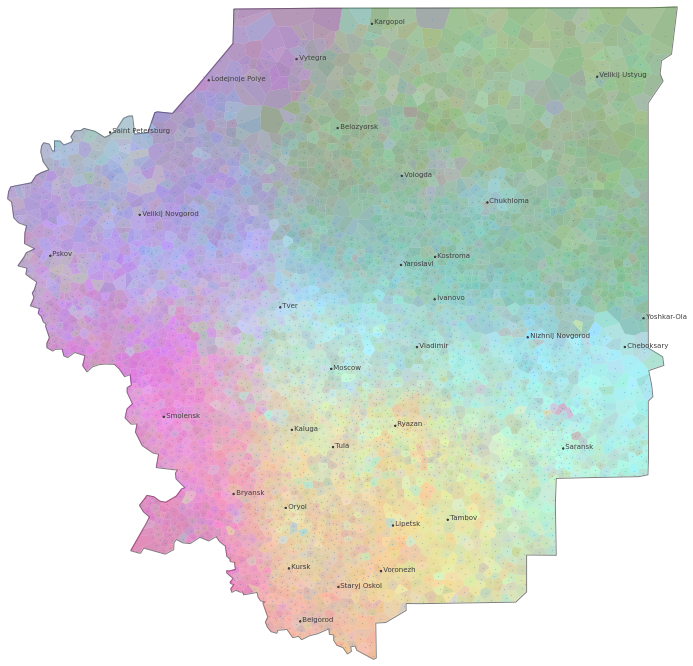

In [100]:
fig, ax = plt.subplots(figsize=(12,12))

plot_voronoi_polys_with_points_in_area(ax, 
                                       boundary_shape, 
                                       region_polys, 
                                       coordinates, 
                                       region_points,

                                       voronoi_and_points_cmap=None,
                                       voronoi_color=colors_for_polygons,
                                       
                                       area_edgecolor=(0,0,0,0.5),
                                       points_markersize=0.01))

plot_points(ax, anchor_cities_coords, 
            markersize=3, 
            marker='*',
            color=['#404040' for _ in range(len(anchor_cities))], 
            labels=[' {}'.format(x) for x in anchor_cities.NAME.tolist()], 
            label_fontsize=7)

plt.axis('off')
plt.margins(0,0)

plt.savefig('maps/{}/MDS.png'.format(VALUE), 
            facecolor='white', 
            bbox_inches='tight',
            pad_inches = 0,
            dpi=300)

plt.show()

#### First dimension (R)

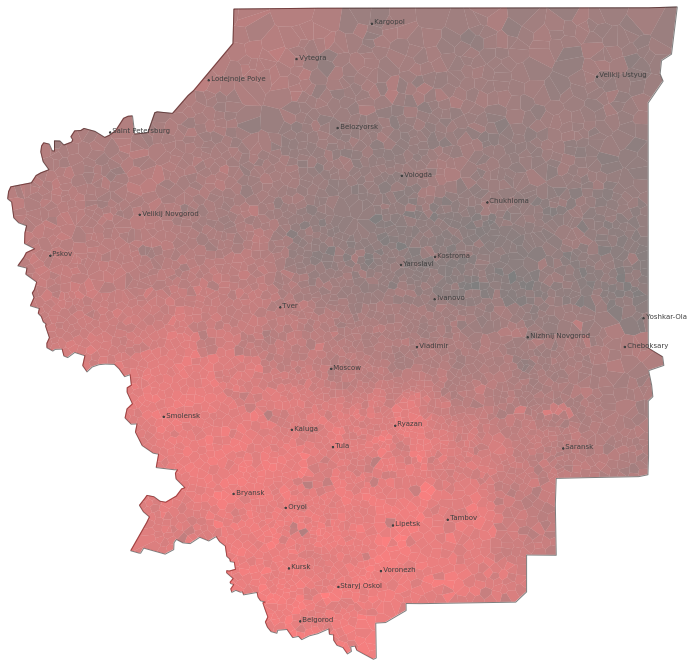

In [108]:
fig, ax = plt.subplots(figsize=(12,12))

plot_voronoi_polys_with_points_in_area(ax, 
                                       boundary_shape, 
                                       region_polys, 
                                       coordinates, 
                                       region_points,

                                       voronoi_and_points_cmap=None,
                                       voronoi_color=r,
                                       
                                       area_edgecolor=(0,0,0,0.5),
                                       points_markersize=0.00)

plot_points(ax, anchor_cities_coords, 
            markersize=3, 
            marker='*',
            color=['#404040' for _ in range(len(anchor_cities))], 
            labels=[' {}'.format(x) for x in anchor_cities.NAME.tolist()], 
            label_fontsize=7)

plt.axis('off')
plt.margins(0,0)

plt.savefig('maps/{}/sep_dims/1DIM.png'.format(VALUE), 
            facecolor='white', 
            bbox_inches='tight', 
            dpi=300)

plt.show()

#### Second dimension (G)

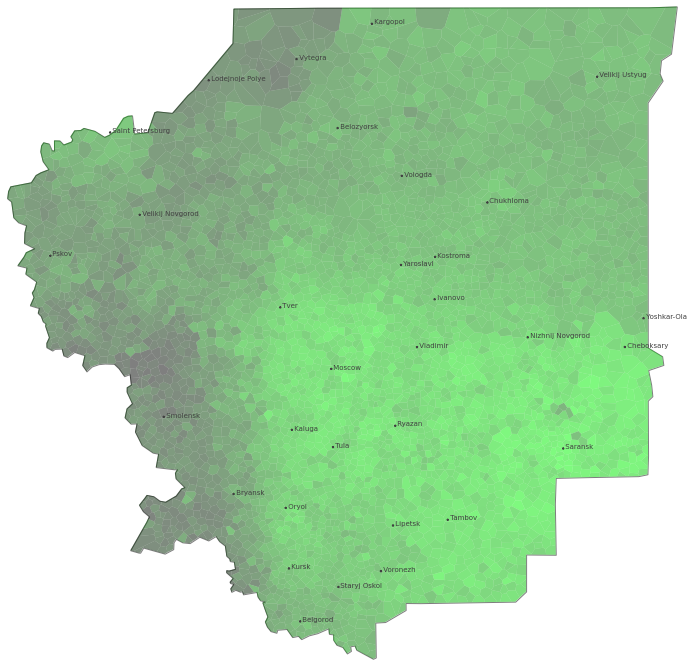

In [109]:
fig, ax = plt.subplots(figsize=(12,12))

plot_voronoi_polys_with_points_in_area(ax, 
                                       boundary_shape, 
                                       region_polys, 
                                       coordinates, 
                                       region_points,

                                       voronoi_and_points_cmap=None,
                                       voronoi_color=g,
                                       
                                       area_edgecolor=(0,0,0,0.5),
                                       points_markersize=0.00)

plot_points(ax, anchor_cities_coords, 
            markersize=3, 
            marker='*',
            color=['#404040' for _ in range(len(anchor_cities))], 
            labels=[' {}'.format(x) for x in anchor_cities.NAME.tolist()], 
            label_fontsize=7)

plt.axis('off')
plt.margins(0,0)

plt.savefig('maps/{}/sep_dims/2DIM.png'.format(VALUE), 
            facecolor='white', 
            bbox_inches='tight', 
            dpi=300)

plt.show()

#### Third dimension (B)

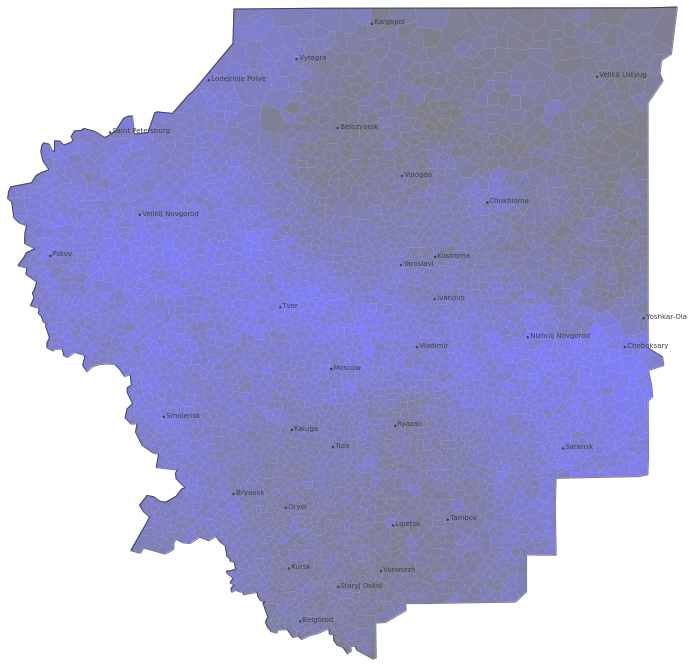

In [110]:
fig, ax = plt.subplots(figsize=(12,12))

plot_voronoi_polys_with_points_in_area(ax, 
                                       boundary_shape, 
                                       region_polys, 
                                       coordinates, 
                                       region_points,

                                       voronoi_and_points_cmap=None,
                                       voronoi_color=b,
                                       
                                       area_edgecolor=(0,0,0,0.5),
                                       points_markersize=0.00)

plot_points(ax, anchor_cities_coords, 
            markersize=3, 
            marker='*',
            color=['#404040' for _ in range(len(anchor_cities))], 
            labels=[' {}'.format(x) for x in anchor_cities.NAME.tolist()], 
            label_fontsize=7)

plt.axis('off')
plt.margins(0,0)

plt.savefig('maps/{}/sep_dims/3DIM.png'.format(VALUE), 
            facecolor='white', 
            bbox_inches='tight', 
            dpi=300)

plt.show()